In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Decision Trees

We first use classification trees to analyze the Carseats data set. In these
data, Sales is a continuous variable, and so we begin by recoding it as a
binary variable. We create a variable, called
High, which takes on a value of Yes if the Sales variable exceeds 8, and
takes on a value of No otherwise.
We also change the variables with levels to integers

In [2]:
df = pd.read_csv('Data/Carseats.csv')
df['High'] = (df.Sales > 8).astype('int')
df = df.drop(['Unnamed: 0'], axis = 1)

df['ShelveLoc'] = df.ShelveLoc.map({'Bad':0, 'Good':1, 'Medium':2})
df['Urban'] = (df.Urban == 'Yes').astype('int')
df['US'] = (df.US == 'Yes').astype('int')
df.head()
display(df.head(3))



,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1


We now use the DecisionTreeClassifier() function to fit a classification tree in order to predict High using all variables but Sales. 
`sklearn` takes in more hyperparameters, so we will set them to be similar to the result in R

Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

Misclasification error rate =  0.0
Total tree node size = 131


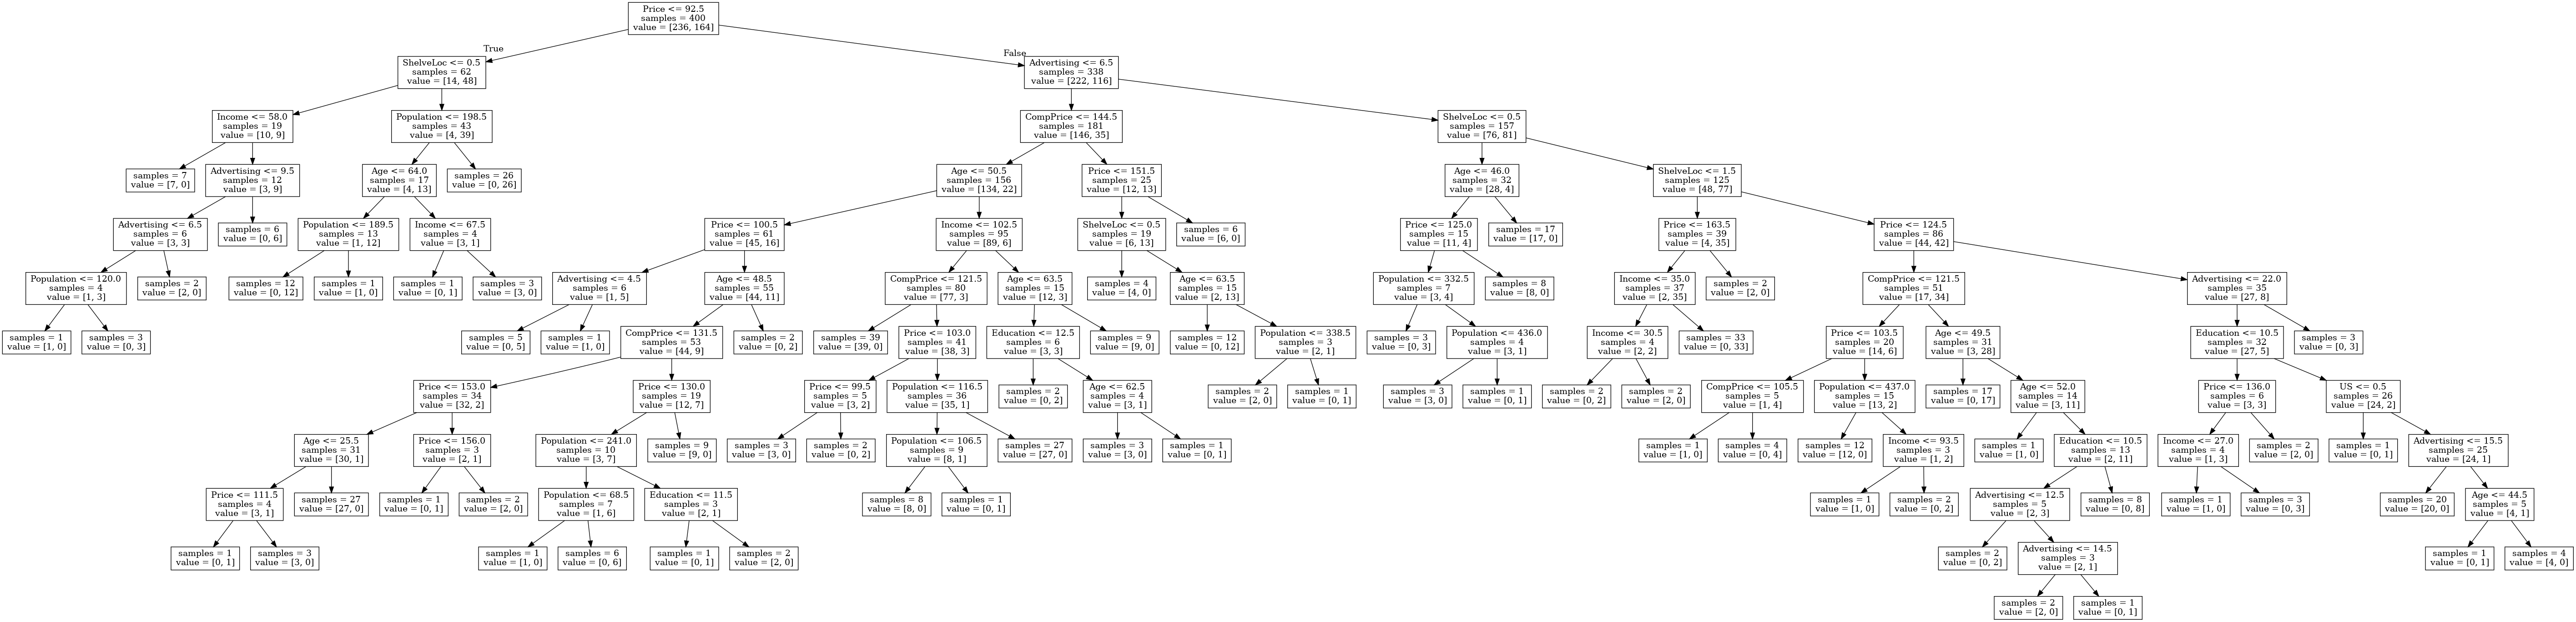

In [3]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import tree
X = df.drop(['Sales', 'High'], axis=1)
display(X.columns)
y = df['High']

dec_tree = DecisionTreeClassifier(random_state =0)
dec_tree.fit(X, y)
score = dec_tree.score(X, y)
print("Misclasification error rate = ", 1-score)
print("Total tree node size =", dec_tree.tree_.node_count)

import graphviz 
import pydotplus
from IPython.display import Image
dot_data = tree.export_graphviz(dec_tree, out_file=None, feature_names=X.columns, impurity =False )
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
# Show graph
Image(graph.create_png())



We see that the training error rate is 0%. SKlearn really overfits the tree, one should be setting max depth or min leaf split parameters to prevent that.
The most important indicator of Sales appears to be Price 
since the first branch differentiates prices.

Text(0.5, 0, 'Importance')

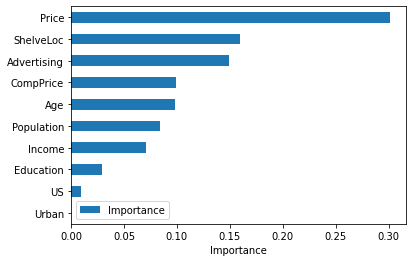

In [4]:

Importance = pd.DataFrame({'Importance':dec_tree.feature_importances_}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh' )
plt.xlabel('Importance')

In order to properly evaluate the performance of a classification tree on
these data, we must estimate the test error rather than simply computing
the training error. We split the observations into a training set and a test
set, build the tree using the training set, and evaluate its performance on
the test data. This approach leads to correct predictions for
around 71% of the locations in the test data set.

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12)
dec_tree = DecisionTreeClassifier(criterion = 'gini')
dec_tree.fit(X_train, y_train)
score = dec_tree.score(X_test, y_test)
print("Misclasification error rate = ", 1-score)
print("Total tree node size =", dec_tree.tree_.node_count)

y_pred = dec_tree.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred))
cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print('Confusion matrix:\n', cm)

Misclasification error rate =  0.265
Total tree node size = 67
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.73      0.76       118
           1       0.66      0.74      0.70        82

    accuracy                           0.73       200
   macro avg       0.73      0.74      0.73       200
weighted avg       0.74      0.73      0.74       200

Confusion matrix:
      No  Yes
No   86   21
Yes  32   61


Next, we consider whether pruning the tree might lead to improved
results. We perform cross-validation in order to determine the optimal level of tree complexity; cost complexity pruning
is used in order to select a sequence of trees for consideration.

In [6]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer

g_cv = GridSearchCV(DecisionTreeClassifier(random_state=0, criterion = 'gini'),
              param_grid={'ccp_alpha': [0, 0.05, 0.075, 0.1, 0.125], 'max_depth': range(3,8), 'min_samples_split': [2,6,8,10,12,15,20] },
              scoring='accuracy', cv=5, refit=True)
g_cv.fit(X_train, y_train)
y_pred = g_cv.best_estimator_.predict(X_test)
score = g_cv.score(X_test, y_test)
print("Misclasification error rate = ", 1-score)
print("Total tree node size =", g_cv.best_estimator_.tree_.node_count)
print('Classification Report:\n', classification_report(y_test, y_pred))
cm = pd.DataFrame(confusion_matrix(y_test,  y_pred.astype("int")).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print('Confusion matrix:\n', cm)

Misclasification error rate =  0.245
Total tree node size = 37
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       118
           1       0.75      0.60      0.67        82

    accuracy                           0.76       200
   macro avg       0.75      0.73      0.74       200
weighted avg       0.75      0.76      0.75       200

Confusion matrix:
       No  Yes
No   102   33
Yes   16   49


We should be plotting training and test set errors to see how we are doing, but can see form the result that it's a bit better, 75.5% accuracy. Our pruned tree looks a bit more easily interpretable and overfits less:

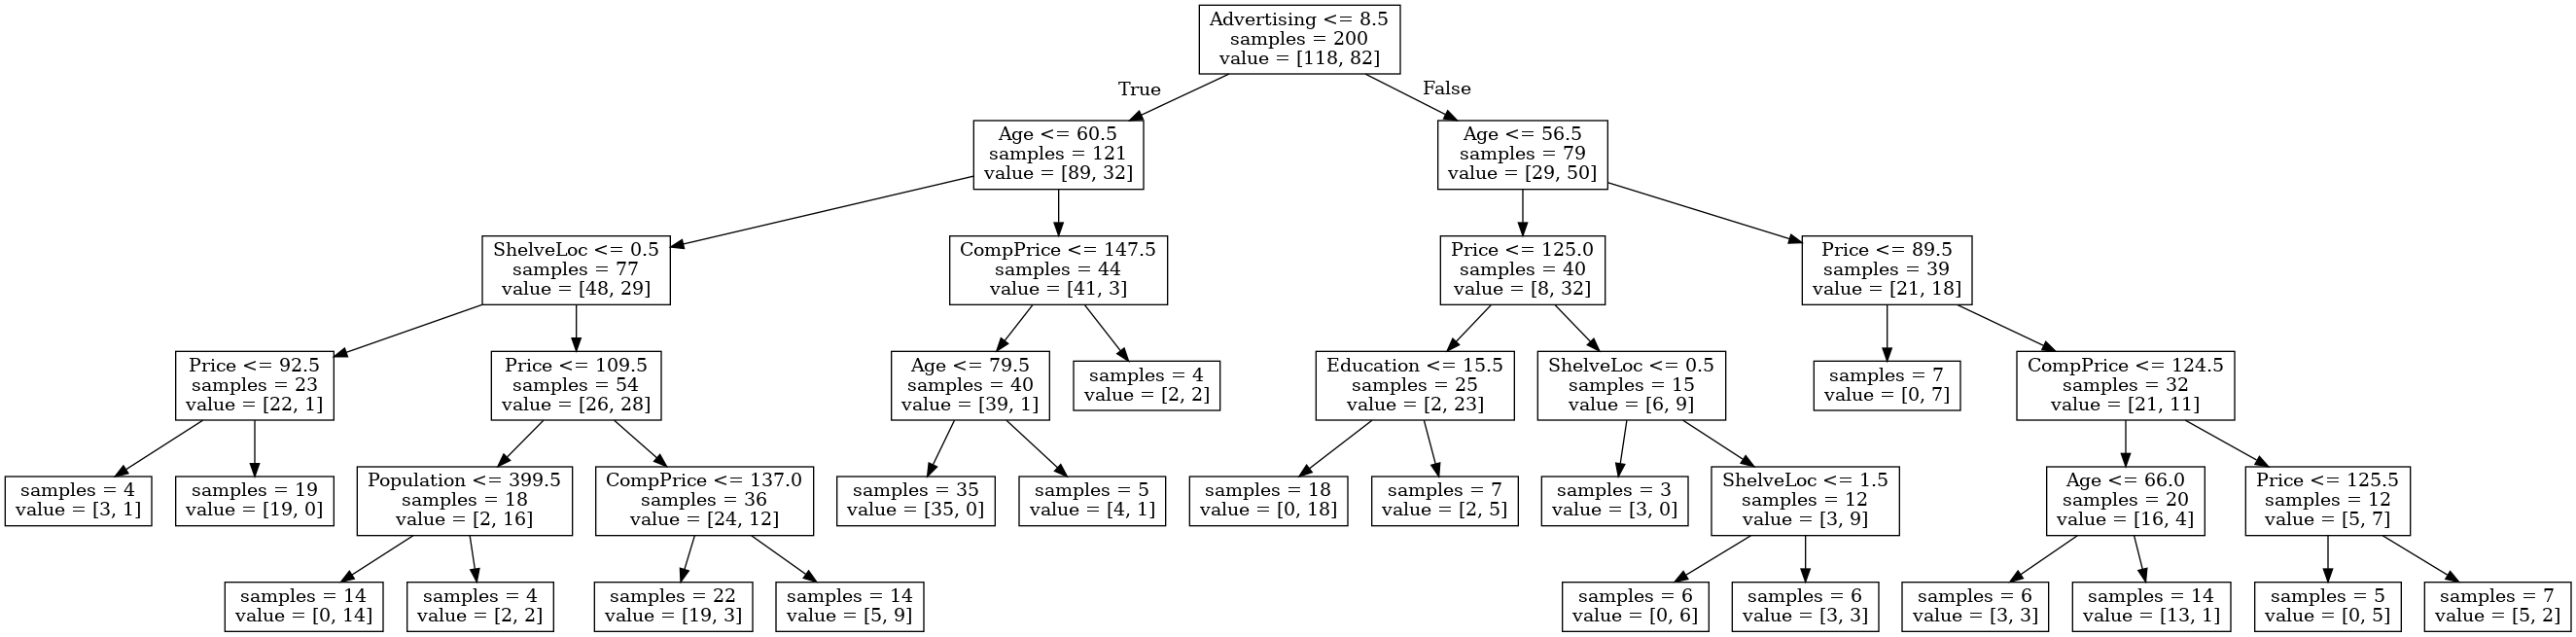

In [7]:
dot_data = tree.export_graphviz(g_cv.best_estimator_, out_file=None, feature_names=X.columns, impurity =False )
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
# Show graph
Image(graph.create_png())


### Fitting regression trees

Here we fit a regression tree to the Boston data set. We want to predict the median house price. First, we create a
training set, and fit the tree to the training data.

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


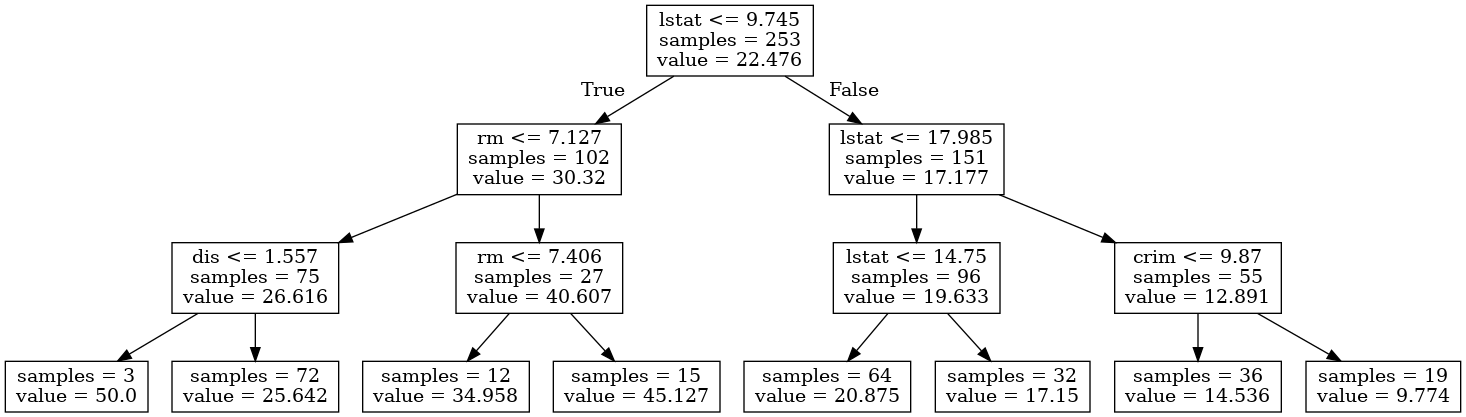

In [8]:
boston = pd.read_csv("Data/Boston.csv")
display(boston.head(5))
y = boston['medv']
X = boston.drop(['medv'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12)
tree_regr = DecisionTreeRegressor(max_depth=3)  # No pruning in scikit-learn
tree_regr.fit(X_train, y_train)
dot_data = tree.export_graphviz(tree_regr, out_file=None, feature_names=X.columns, impurity =False )
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
# Show graph
Image(graph.create_png())



The variable lstat measures the percentage of individuals with lower
socioeconomic status. The tree indicates that lower values of lstat correspond to more expensive houses. The tree predicts a house price
of $45, 127 for larger homes in suburbs in which residents have high socioeconomic status (rm>=7.406 and lstat<9.745).


Now pruning:

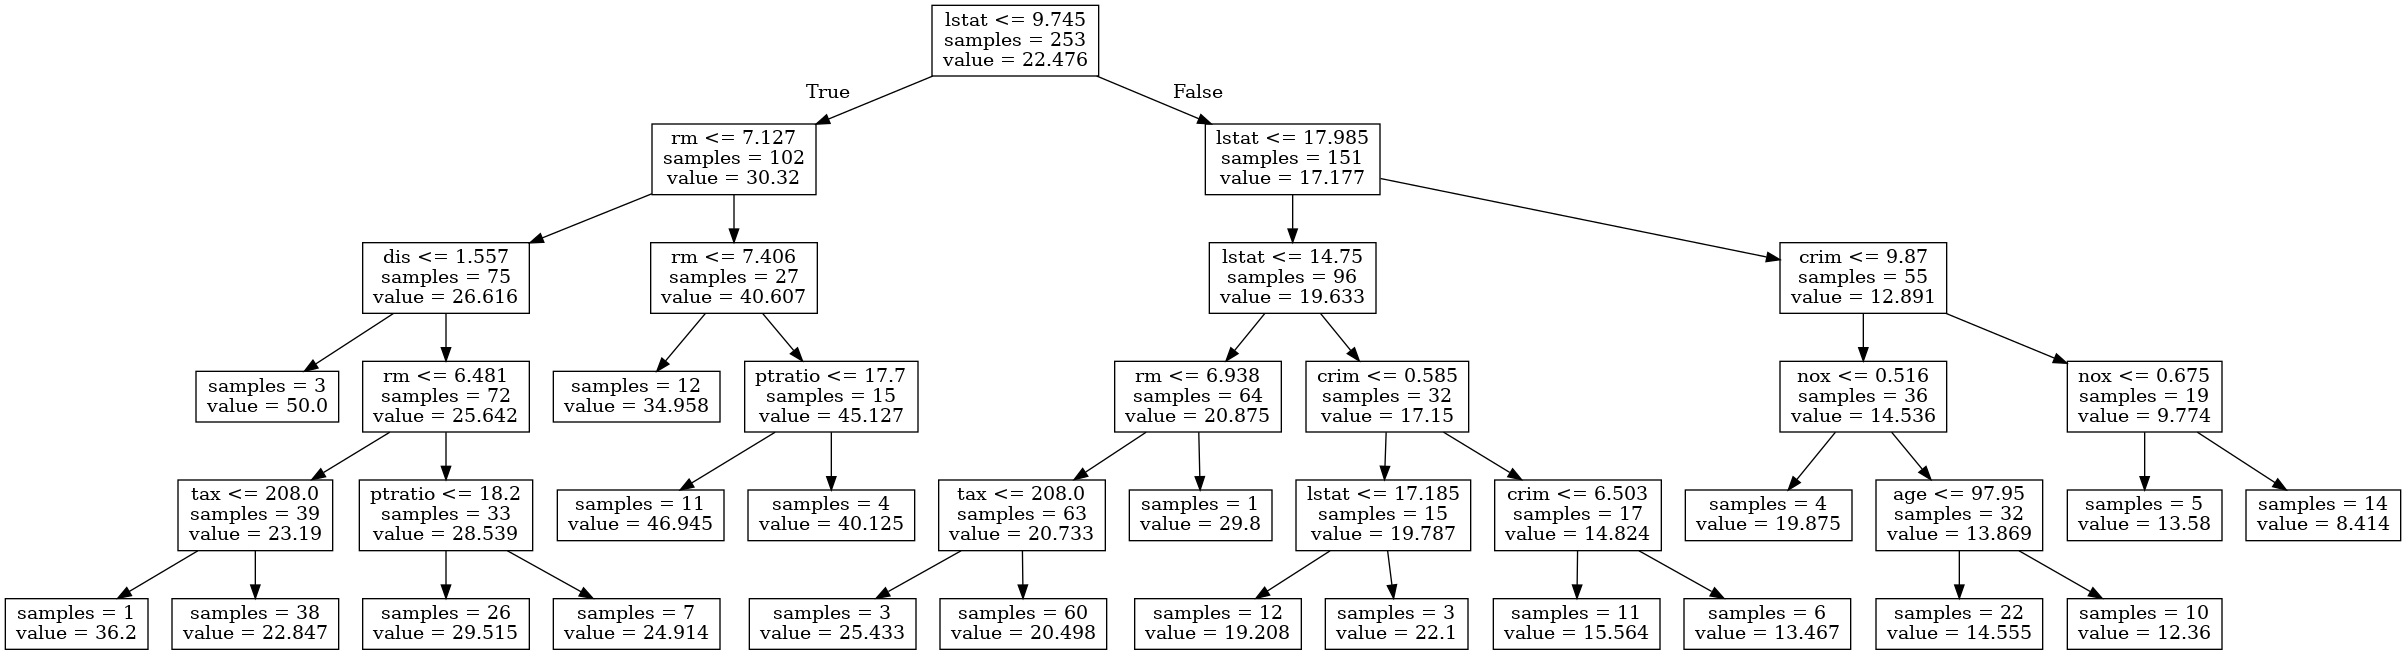

'Mean square error is: 17.385502001108353'

In [9]:
from sklearn.metrics import mean_squared_error

g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),
              param_grid={'ccp_alpha': [0, 0.05, 0.1, 0.5, 1, 3, 7, 10], 'max_depth': range(2,8), 'min_samples_split': [2,6,8,10,12,15,20] },
              scoring='neg_mean_squared_error', cv=5, refit=True)
g_cv.fit(X_train, y_train)
dot_data = tree.export_graphviz(g_cv.best_estimator_, out_file=None, feature_names=X.columns, impurity =False )
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
# Show graph
display(Image(graph.create_png()))


y_pred = g_cv.best_estimator_.predict(X_test)
score = g_cv.score(X_test, y_test)

display(f"Mean square error is: {-score}")

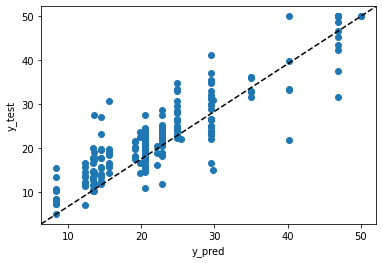

In [10]:

# Prediction
plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In other words, the test set MSE associated with the regression tree is
17.38. The square root of the MSE is therefore around 4.16, indicating
that this model leads to test predictions that are within around $4,160 of
the true median home value for the suburb.

### 8.3.3 Bagging and Random Forests

Here we apply bagging and random forests to the Boston data.

MSE =  13.19385375494071


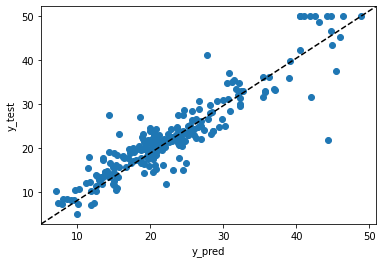

In [11]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
# Bagging
reg = BaggingRegressor(random_state=0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

The test set MSE associated with the bagged regression tree is 13.19, much less that that obtained using an optimally-pruned single tree.

For random forests, we try considering 6 features:

MSE =  11.521726324110675


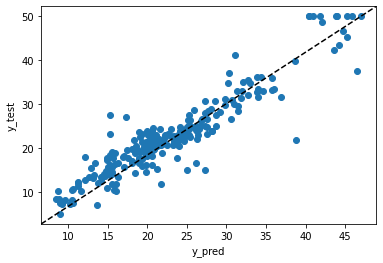

In [12]:
reg = RandomForestRegressor(random_state=0, max_features=6)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

plt.scatter(y_pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

The test set MSE is 11.52; this indicates that random forests yielded an
improvement over bagging in this case.
We can view the importance of each variable.

Text(0.5, 0, 'Importance')

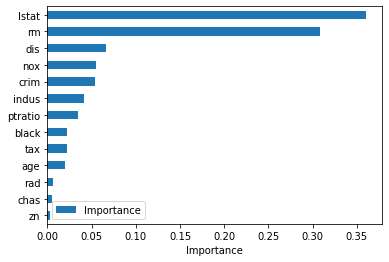

In [13]:
Importance = pd.DataFrame({'Importance':reg.feature_importances_}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh' )
plt.xlabel('Importance')

The results indicate that across all of the trees considered in the random
forest, the wealth level of the community (lstat) and the house size (rm)
are by far the two most important variables.

### 8.3.4 Boosting
We want 5000 trees, and the depth=4 limits the depth of each tree.


MSE =  12.614605051959922


Text(0.5, 0, 'Importance')

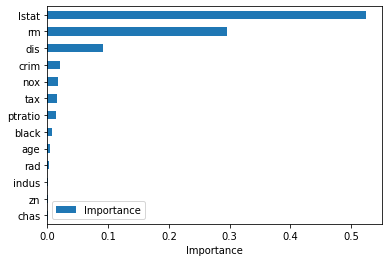

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.001, random_state=0, max_depth=4)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

Importance = pd.DataFrame({'Importance':gbr.feature_importances_}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh' )
plt.xlabel('Importance')

We see that lstat and rm are by far the most important variables. We can
also produce partial dependence plots for these two variables. These plots partial
dependence
plot
illustrate the marginal effect of the selected variables on the response after
integrating out the other variables. In this case, as we might expect, median
house prices are increasing with rm and decreasing with lstat.

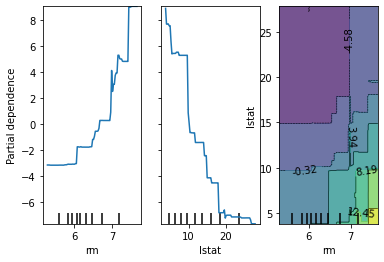

In [15]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(gbr, X_train, features=[5,12,(5,12)]) 

The test MSE obtained is 12.4; similar to the test MSE for random forests
and superior to that for bagging. If we want to, we can perform boosting
with a different value of the shrinkage parameter λ in (8.10). Here we take λ = 0.2.

MSE =  12.868340131257453


Text(0.5, 0, 'Importance')

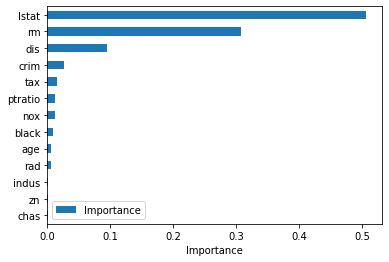

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.2, random_state=0, max_depth=4)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

Importance = pd.DataFrame({'Importance':gbr.feature_importances_}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh' )
plt.xlabel('Importance')

In this case, using λ = 0.2 leads to a slightly higher test MSE than λ = 0.001